In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

In [3]:
df_final = pd.read_csv('../Data/df_final.csv', index_col="time")
X = df_final.drop(columns=['generation solar','generation wind onshore', 'forecast wind onshore day ahead', 'forecast solar day ahead'])
y_solar = df_final['generation solar']
y_wind = df_final['generation wind onshore']

In [13]:
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2015-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_solar_train,y_solar_test = split_by_date(y_solar,train_end_date)

# Standardize all columns except target
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [14]:
# Initialize and train the XGBoost classifier
xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train_scaled, y_solar_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [18]:
param_grid = {
    'max_depth': [2,5,10],
    'alpha': [2,5,10],
    'learning_rate': [0.1, 0.2,0.5],
    'n_estimators': [20,50,80],
    'colsample_bytree': [0.3, 0.5,0.8]
}

grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_scaled, y_solar_train)

# Print best parameters found by GridSearchCV
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'alpha': 5, 'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 80}


In [24]:
# Re-train the model with the best parameters on the full training set
xgb_optimized = XGBRegressor(**best_params, use_label_encoder=False, objective ='reg:squarederror', random_state=42)
xgb_optimized.fit(X_train_scaled, y_solar_train)

# Make predictions on the test set
y_solar_pred_optimized = xgb_optimized.predict(X_test_scaled)

# Calculate and print the accuracy on the test set
MSE = mean_squared_error(y_solar_test, y_solar_pred_optimized)
print("Test set MSE with optimized parameters: {:.2f}".format(MSE))

Test set accuracy with optimized parameters: 1725297.96


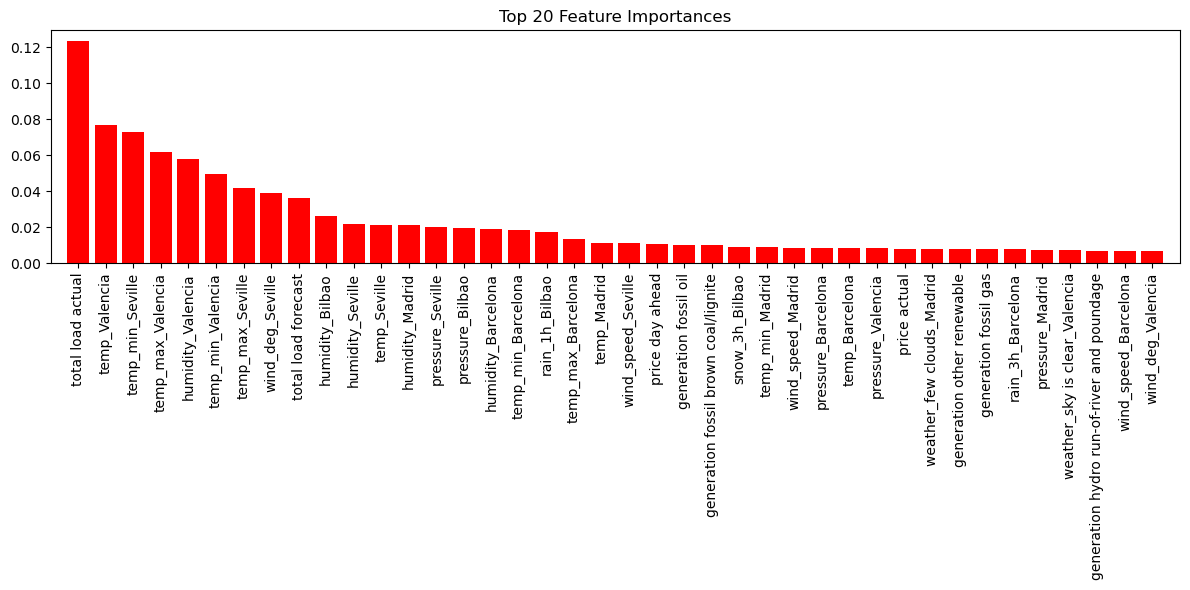

In [28]:
importances = xg_reg.feature_importances_
indices = np.argsort(importances)[::-1][:40]  # Select top 20 most important features
plt.figure(figsize=(12, 6))  # Increase width of the plot
plt.title('Top 20 Feature Importances')
plt.bar(range(len(indices)), importances[indices], color='r', align='center')
plt.xticks(range(len(indices)), X_train.columns[indices], rotation=90)
plt.xlim([-1, len(indices)])
plt.tight_layout()  # Adjust layout for better readability
plt.show()


In [19]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


df_final = pd.read_csv('../Data/df_final.csv', index_col="time")


def prep_split(df, columns, label, train_end_date, hours):
    # Add a column with the label shifted by "hours" rows
    df['label_shifted'] = df[label].shift(-hours)
    
    # Drop the last "hours" rows as they have no label values
    df = df.iloc[:-hours]
    
    def split_by_date(X, train_end_date):
        if not isinstance(train_end_date, pd.Timestamp):
            train_end_date = pd.Timestamp(train_end_date)

        # Convert index of X and y to Timestamp objects if they are strings
        if isinstance(X.index[0], str):
            X.index = pd.to_datetime(X.index)

        X_train = X[X.index <= train_end_date].drop(columns=['label_shifted'])
        X_test = X[X.index > train_end_date].drop(columns=['label_shifted'])

        return X_train, X_test

    X = df.drop(columns=columns)
    y = df['label_shifted']

    X_train, X_test = split_by_date(X, train_end_date)
    y_train, y_test = split_by_date(y, train_end_date)

    # Standardize all columns except target
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

    X_test_scaled = scaler.transform(X_test)
    X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test


In [20]:
# Example usage
X_train, X_test, y_train, y_test = prep_split(df_final, 
                                               columns=['generation solar'], 
                                               label='generation solar', 
                                               train_end_date='2015-12-31 23:00:00+00:00',
                                               hours=24)

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

def XGB(X_train, X_test, y_train, y_test, param_grid, random_state=None):
    # Initialize and train the XGBoost classifier
    xg_reg = XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                    max_depth = 5, alpha = 10, n_estimators = 10, random_state=random_state)
    xg_reg.fit(X_train, y_train)

    # Perform GridSearchCV
    grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)
    grid_search.fit(X_train, y_train)

    # Print best parameters found by GridSearchCV
    best_params = grid_search.best_params_
    print("Best parameters:", best_params)

    # Re-train the model with the best parameters on the full training set
    xgb_optimized = XGBRegressor(**best_params, use_label_encoder=False, objective ='reg:squarederror', random_state=random_state)
    xgb_optimized.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred_optimized = xgb_optimized.predict(X_test)

    # Calculate and print the MSE on the test set
    MSE = mean_squared_error(y_test, y_pred_optimized)
    print("Test set MSE with optimized parameters: {:.2f}".format(MSE))
    
    return xgb_optimized, best_params, MSE

In [22]:
# Example usage

param_grid = {
    'max_depth': [2,10],
    'alpha': [2,10],
    'learning_rate': [0.1,0.5],
    'n_estimators': [20,80],
    'colsample_bytree': [0.3,0.8]
}
xgb_optimized, best_params, MSE = XGB(X_train, X_test, y_train, y_test, param_grid, random_state=42)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'alpha': 10, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80}
Test set MSE with optimized parameters: 616424.29


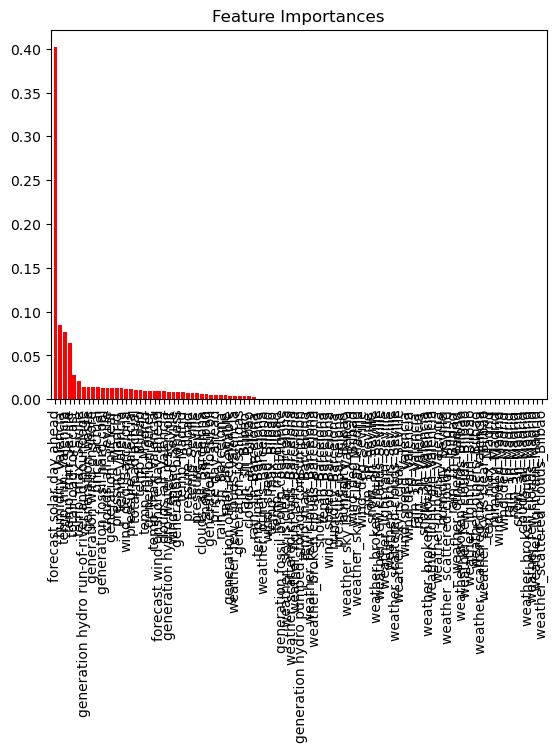

In [23]:
# Get and plot feature importances from the model
importances = xgb_optimized.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color='r', align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [25]:
# Define the random state
random_state = 42

# Define the hours
hours_list = [3, 6, 12, 24]

results = {}

for hours in hours_list:
    print(f"Testing for {hours} hours ahead...")
    # Prepare data using prep_split function
    X_train, X_test, y_train, y_test = prep_split(df_final, 
                                                   columns=['generation solar'], 
                                                   label='generation solar', 
                                                   train_end_date='2015-12-31 23:00:00+00:00',
                                                   hours=hours)

    # Train and evaluate XGBoost model
    xgb_optimized, best_params, MSE = XGB(X_train, X_test, y_train, y_test, param_grid, random_state=random_state)
    
    # Save the results
    results[hours] = {'best_params': best_params, 'MSE': MSE}

# Print results
for hours, result in results.items():
    print(f"For {hours} hours ahead, best parameters are: {result['best_params']} and MSE is: {result['MSE']}")

Testing for 3 hours ahead...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'alpha': 2, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80}
Test set MSE with optimized parameters: 1170275.66
Testing for 6 hours ahead...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'alpha': 10, 'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80}
Test set MSE with optimized parameters: 2208589.11
Testing for 12 hours ahead...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'alpha': 2, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}
Test set MSE with optimized parameters: 1321616.94
Testing for 24 hours ahead...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters: {'alpha': 10, 'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 80}
Test set MSE with optimize